# Introdução à Inteligência Artificial

**Unidade 2**

Discente: Samnatha Dantas Medeiros

> Dataset utilizado: https://github.com/tmfilho/akcdata/blob/master/data/akc-data-latest.csv

## Ambiente, funções e _misc_
A seção a seguir contém a inicialização deste notebook (bibliotecas a serem utilizadas, funções de propósitos específicos e algumas variáveis para ficarem 'separadas' dos blocos adjacentes).

In [1]:
#pip install imbalanced-learn
#pip install termcolor 

In [2]:
# Dependências
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay)
 # classificação

In [3]:
# Funções que serão utilizadas ao longo do pré-processamento de dados
# parãmetros: dataframe, coluna numérica, coluna que armazena valor do grupo (toy, herding, sporting)

'''
Esta função substitui valores não-numéricos(caso hajam) e nulos 
de colunas numéricas do dataframe pela mediana
de suas colunas de acordo com o grupo dos cães (toy, pastoreiro e etc).
'''
def replace_with_median(df, n_col, g_col):
  # transforma os valores da coluna popularity em float
  # for c in n_col:
  #   if c == 'popularity': 
  #     df[c].replace('of', np.nan, inplace=True)
  #     df[c] = pd.to_numeric(df[c], errors='coerce')  # Convertendo para float
  
  # Calcula a mediana por grupo
  median_by_group = df.groupby(g_col)[n_col].transform('median')
  
  # Substitui valores nulos e strings pela mediana do grupo  
  df[n_col] = df[n_col].fillna(median_by_group)
    
  return df

'''
Esta função preenche valores categóricos com a moda
'''
def replace_with_mode(df, cols, g_col):
  for c in cols:
    for group, group_data in df.groupby(g_col):
      c_mode = group_data[c].mode()[0]
      df.loc[df[g_col] == group, c] = df.loc[df[g_col] == group, c].fillna(c_mode)

  return df

'''
A seguinte função irá imprimir os valores únicos de cada coluna 
do dataframe a fim de ajudar a visualizar os intervalos ou os 
conjuntos de valores de cada coluna para eventuais análises
'''
def all_unique_in(df):
  for c in df.columns:
    valores_unicos = df[c].unique()
    if np.issubdtype(valores_unicos.dtype, np.number):  # Verifica se a coluna contém apenas valores numéricos
      valores_unicos = np.sort(valores_unicos)  # Ordena os valores únicos numéricos em ordem crescente
    else:
      valores_unicos = np.sort(valores_unicos.astype(str))  # Converte para strings e ordena
      # valores_unicos.sort()  # Ordena os valores únicos não numéricos

    print(f"Valores únicos da coluna '{c}':")
    print(valores_unicos)
    print("--------------------")


'''
Essa função irá separar os 3 adjetivos de temperamentos de cães em 3 novas colunas.
Isso irá permitir o uso de Label Encoding de forma mais organizada.
'''
def temperaments_cols(df):
  # Separar os adjetivos em novas colunas
  df_temperament = df["temperament"].str.split(", ", expand=True)

  # Renomear as novas colunas
  num_adjectives = len(df_temperament.columns)
  new_columns = [f"temperament_{i+1}" for i in range(num_adjectives)]
  df_temperament.columns = new_columns

  # Concatenar as novas colunas com o DataFrame original
  df = pd.concat([df, df_temperament], axis=1)

  return df

'''
Esta função permite excluir múltiplas colunas
dado um array de colunas
'''
def drop_cols(df, cols):
  return df.drop(columns=cols)



In [4]:
# colunas numéricas
numeric_cols = [
  'min_height',
  'max_height',
  'min_weight',
  'max_weight',
  'min_expectancy',
  'max_expectancy',
  'grooming_frequency_value',
  'energy_level_value',
  'shedding_value',
  'trainability_value',
  'demeanor_value'
]

# colunas categóricas (apenas as colunas group e ___ serão preservadas)
text_cols = [
  'dog_breed',
  'description',
  'grooming_frequency_category',                 
  'shedding_category',
  'energy_level_category',
  'trainability_category',
  'demeanor_category',
]

# utilizado para agrupamento de valores
mode_cols = ['temperament'] 

group_col = 'group'

In [5]:
# Criando o dataframe
og = pd.read_csv('./dog_breeds.csv', encoding='utf-8') # original
df = pd.read_csv('./dog_breeds.csv', encoding='utf-8') # dataframe final

## Questão 1 
Execute o pré-processamento necessário para que você possa executar métodos de aprendizado supervisionado e não supervisionado;

### Resolução

O pré-processamento dos dados é uma etapa essencial para a construção de um modelo, pois utiliza diversas técnicas para melhorar a qualidade dos dados. 

Para esta base de dados, caso hajam valores ausentes, eles serão substituídos pela:

* mediana de suas respectivas colunas (valores numéricos)
* moda de suas respectivas colunas (valores categóricos)

E algumas colunas serão removidas do dataframe por não serem revelantes para o problema a ser resolvido ou por já existir uma coluna equivalente com valores numéricos, como é o caso de `trainability_value` e `trainability_category`. 

Nas células de texto código adjacentes haverá uma descrição/explicação breve sobre as decisões tomadas para o pré-processamento dos dados.

> Para realizar a comparação com a base de dados original e o dataframe pré-processado, será feito uso das variáveis `og` e `df`, respectivamente.

#### Exclusão de Colunas 
As seguintes colunas serão excluídas do dataframe, pois elas são irrevalantes para o problema dada a correlação entre esses atributos e outras justificativas (descritas abaixo). 
* **Nome da raça de cão**, não é relevante pois cada objeto do dataframe é sobre uma determinada raça de cão e cada raça possui seus valores mínimos e máximos de atributos pré-estabelecidos (altura, peso, temperamento, etc). Logo, não é interessante manter essa coluna, pois o problema a ser resolvido com o modelo não é prever a qual raça de cão um determinado cão pertence.
* Descrição é um texto bastante extenso que pode ser de difícil processamento, além de que no próprio texto cita algumas das características já presente em outras colunas.
* Popularidade (coluna removida na questão 2, pois a correlação deste atributo com os demais é baixa)
* E, como já mencionado anteriormente, as colunas abaixo serão excluídas do dataframe devido a existência de colunas que possuem valores numéricos equivalentes a eles (por exemplo, em energy_level_value 0.2 equivale a energy_level_categroy Couch Potato)
  * energy_level_categroy
  * demeanor_category 
  * grooming_frequency_category
  * shedding_category 
  * trainability_category

In [6]:
# renomeando a primeira coluna do dataframe (originalmente sem nome)
df = df.rename(columns={df.columns[0]: 'dog_breed'})

# Removendo colunas categóricas, visto que já existem as colunas numéricas correspondentes ao seu valor
df = drop_cols(df, text_cols)


#### Valores únicos
Apenas para registrar os valores únicos de cada coluna com o propósito de visualizar intervalos ou grupos de valores.

```python
# função dedicada para obter todos os valores únicos de uma única vez
all_unique_in() 
```

##### Group
* Foundation Stock Service 
* Herding Group 
* Hound Group
* Miscellaneous Class 
* Non-Sporting Group 
* Sporting Group
* Terrier Group 
* Toy Group 
* Working Group

##### Grooming_frequency_value
* 0.2 - Occasional Bath/Brush
* 0.4 - Weekly Brushing
* 0.6 - 2-3 Times a Week Brushing
* 0.8 - Daily Brushing
* 1.0 - Specialty/Professional

##### Shedding_value
* 0.2 - Infrequent
* 0.4 - Occasional
* 0.6 - Seasonal
* 0.8 - Regularly
* 1.0 - Frequent

##### Energy_level_value
* 0.2 - Couch Potato
* 0.4 - Calm
* 0.6 - Regular Exercise
* 0.8 - Energetic
* 1.0 - Needs Lots of Activity

##### Trainability_value
* 0.2 - May be Stubborn
* 0.4 - Independent
* 0.6 - Agreeable
* 0.8 - Easy Training
* 1.0 - Eager to Please

##### Demeanor_value
* 0.2 - Aloof/Wary
* 0.4 - Reserved with Strangers
* 0.6 - Alert/Responsive
* 0.8 - Friendly
* 1.0 - Outgoing

In [7]:
# exibe os 5 primeiros elementos do dataframe
og.head() 
# exibe as colunas do dataframe
og.columns
# para dar um resumo de valores não nulos encontrados
og.info() 
# para retornar um resumo estatístico das variáveis numéricas
og.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
count,277.000000,277.000000,275.000000,275.000000,274.000000,274.000000,270.000000,257.000000,271.000000,253.000000,252.000000
mean,44.225801,52.720588,17.888858,27.291416,11.306569,13.832117,0.425926,0.529183,0.712915,0.624506,0.620635
std,14.238298,15.885454,12.290600,19.061416,1.817949,2.016668,0.198306,0.189068,0.168927,0.247271,0.201713
min,12.700000,17.780000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,33.020000,38.100000,8.164663,12.927383,10.000000,13.000000,0.200000,0.400000,0.600000,0.400000,0.400000
50%,45.085000,53.340000,15.875733,24.947580,12.000000,14.000000,0.400000,0.600000,0.600000,0.600000,0.600000
75%,55.880000,66.040000,22.679619,34.019428,12.000000,15.000000,0.600000,0.600000,0.800000,0.800000,0.800000
max,76.200000,88.900000,68.038855,108.862169,16.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preenchendo valores ausentes
Como há diferentes grupos de cães e cada um tem as suas características, os valores nulos serão substituídos de acordo com o grupo que o cão pertence. Ou seja, caso um cão do grupo Toy estiver com a altura mínima ausente, esse valor será substituído pela mediana de altura mínima de cães do grupo Toy. Isso irá auxiliar a possuir valores que condizem com a realidade.

> Por exemplo: o peso mínimo e máximo de um cão do grupo toy não pode ser substituído com a mediana dos pesos de todas as raças envolvidas, pois pode fugir de um valor real. 

**Valores numéricos**
* popularity _*_
* min_height                      
* max_height                      
* min_weight                      
* max_weight                      
* min_expectancy                  
* max_expectancy
* grooming_frequency_value   
* energy_level_value 
* shedding_value   
* trainability_value
* demeanor_value

**Valores categóricos**
* group
* temperament _**_

> _*_ Observação quanto ao atributo de **popularidade**: o tipo de dados dessa coluna estava como object, assim fugindo de valores esperados (como inteiro ou float). Analisando o arquivo original, além dos valores ausentes encontrados, existia linhas dessa coluna preenchida com valores não numéricos. Sendo assim, ocorreu uma conversão do tipo de dado dessa coluna (object para float) e assim foi possível tratar os dados ausentes. No entando, como a popularidade de todos os cães do grupo *Foundation Stock Service* e *Miscellaneous Class* é vazia, não foi possível tratar essa coluna da mesma forma que as demais, portanto, os valores ausentes da coluna popularidade foram substituídos com a mediana geral de popularidade de todos os cães do dataframe. Outra alternativa poderia ser a exclusão da coluna, mas no atual momento, não se viu a necessidade.

> _**_ Observação quanto ao atributo **temperament**: foi implementada uma função que cria 3 novas colunas contendo cada um dos adjetivos da coluna original. Essa coluna vai ser preservada pois ela pode ser importante ao se classificar um cão em um determinado grupo canino junto aos demais atributos. Posteriormente, esses valores passarão pelo process de Label Encoding para atribuir um valor numérico correspondente (a partir de uma lista que possui os valores únicos de cada uma das colunas). Por fim, é notado que alguns dos atributos estão escritos como "Smart and Playful" ou então "Active but hard-working", isso dificulta a separação concisa desses adjetivos nas novas colunas. Pode-se observar isso no momento que se vai avaliar a quantidade de valores nulos totais em cada coluna, nas colunas temperament_2 e temperament_3 há valores 1 e 2 valores nulos, respectivamente. Mas como são poucas as ocorrências, elas poderiam ser tratadas manualmente (manipulando a planilha original).

In [8]:
# Preenchendo valores ausentes
df = replace_with_median(df, numeric_cols, group_col)
df = replace_with_mode(df, mode_cols, group_col) 

# Verificando se ficou algum valor ausente no data frame após o pré-processamento
df.isnull().sum()

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
dtype: int64

In [9]:
df = temperaments_cols(df)

In [10]:
# Soma de valores nulos encontrados no data frame (antes do pré-processamento)
df.isnull().sum() 

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
temperament_1                0
temperament_2                1
temperament_3                2
dtype: int64

In [11]:
# função dedicada para obter todos os valores únicos de cada coluna de uma única vez
all_unique_in(df)

Valores únicos da coluna 'temperament':
['Active, Outgoing, Sweet-Natured' 'Active, Proud, Very Smart'
 'Adaptable, Friendly, Gentle' 'Adaptable, Gentle, Smart'
 'Adaptable, Playful, Smart' 'Affectionate, Active, Enthusiastic'
 'Affectionate, Adaptable, Gentle' 'Affectionate, Adventurous, Athletic'
 'Affectionate, Alert, Curious' 'Affectionate, Alert, Intelligent'
 'Affectionate, Alert, Lively' 'Affectionate, Bright, Sensitive'
 'Affectionate, Confident, Bold' 'Affectionate, Courageous, Spirited'
 'Affectionate, Courageous, Strong-Willed'
 'Affectionate, Dignified, Even-Tempered'
 'Affectionate, Eager, Enthusiastic' 'Affectionate, Friendly, Independent'
 'Affectionate, Gentle, Energetic' 'Affectionate, Gentle, Graceful'
 'Affectionate, Gentle, Sociable' 'Affectionate, Happy, Plucky'
 'Affectionate, Intelligent, Active'
 'Affectionate, Intelligent, Enthusiastic'
 'Affectionate, Intelligent, Kind' 'Affectionate, Intelligent, Majestic'
 'Affectionate, Intelligent, Outgoing' 'Affectionate,

In [12]:
df['temperament_2'].fillna('Unknown', inplace=True)
df['temperament_3'].fillna('Unknown', inplace=True)

print(df.isnull().sum()) # temperament_2 tinha 1 valor nulo antes, temperament_3 tinha 2 valor nulo antes

temperament_values = df['temperament_1'].unique().tolist()
temperament_values += df['temperament_2'].unique().tolist()
temperament_values += df['temperament_3'].unique().tolist()
temperament_values_unique = list(set(temperament_values))
temperament_values_sorted = sorted(temperament_values_unique)

print(temperament_values_sorted)
print(len(temperament_values_sorted)) # 141 adjetivos (podendo ser por volta de 135, pois não foram tratados strings com a presença de conectivos ou que não tivessem vírgulas para separar os atributos das sentenças)

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
temperament_1                0
temperament_2                0
temperament_3                0
dtype: int64
['Active', 'Adaptable', 'Adventurous', 'Affectionate', 'Agile', 'Alert', 'Alert and Intelligent', 'Amiable', 'Amusing', 'Aristocratic', 'Athletic', 'Attentive', 'Boisterous', 'Bold', 'Bouncy', 'Brave', 'Bright', 'Busy', 'Calm', 'Canny', 'Charismatic', 'Charming', 'Cheerful', 'Clever', 'Comical', 'Confident', 'Confident Guardian', 'Courageous', 'Courteous', 'Curious', 'Dashing', 'Deeply Affectionate', 'Deeply Devoted', 'Dependable', 'Determined', 'Devoted',

In [13]:
'''
* Caso especial: popularidade dos grupos Miscellaneous Class e Foundation Stock Service
Esses dois grupos não possuem valor de popularidade para nenhum dos cães que pertecem ao grupo.
Solução: atribuir um valor de popularidade 
'''

print(df.isnull().sum()) # antes

# Converte popularity para float e substitui os valores nulos pela mediana (de acordo com o grupo)
df['popularity'] = df['popularity'].replace('of', pd.NA)
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['popularity'] = df['popularity'].fillna(df['popularity'].median())

print(df.isnull().sum()) # depois

# salvando em um novo arquivo .csv (para comparações)
df.to_csv('dogs1.csv', index=False)

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
temperament_1                0
temperament_2                0
temperament_3                0
dtype: int64
temperament                 0
popularity                  0
min_height                  0
max_height                  0
min_weight                  0
max_weight                  0
min_expectancy              0
max_expectancy              0
group                       0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
temperament_1               0
temperamen

## Questão 2
Escolha um dos atributos de entrada para que passe a ser um atributo de saída e assim você tenha um problema supervisionado em mãos;


### Resolução
No aprendizado supervisionado, precisa-se de rótulos ou respostas conhecidas para treinar um modelo e realizar previsões ou classificações.

Dentre os atributos preservados no dataframe (`df.columns`), será utilizado o atributo de `group`, pois uma determinada raça de cão se enquadra em um grupo com base no seu porte (altura, peso), comportamento, treinamento e etc (ou seja, os atributos numéricos preservados na base de dados após o pré-processamento dos mesmos). 

No entanto, como são valores categóricos, eles irão passar por mais um tratamento. Irei utilizar a técnica de codificação de rótulos **Label Encoding**, ela irá transformar cada categoria em um valor inteiro correspondente.

In [14]:
del df['temperament']

In [15]:
print(df.columns)

Index(['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight',
       'min_expectancy', 'max_expectancy', 'group', 'grooming_frequency_value',
       'shedding_value', 'energy_level_value', 'trainability_value',
       'demeanor_value', 'temperament_1', 'temperament_2', 'temperament_3'],
      dtype='object')


C:\Users\saman\AppData\Local\Temp\ipykernel_4952\3833657664.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_encoded.corr()


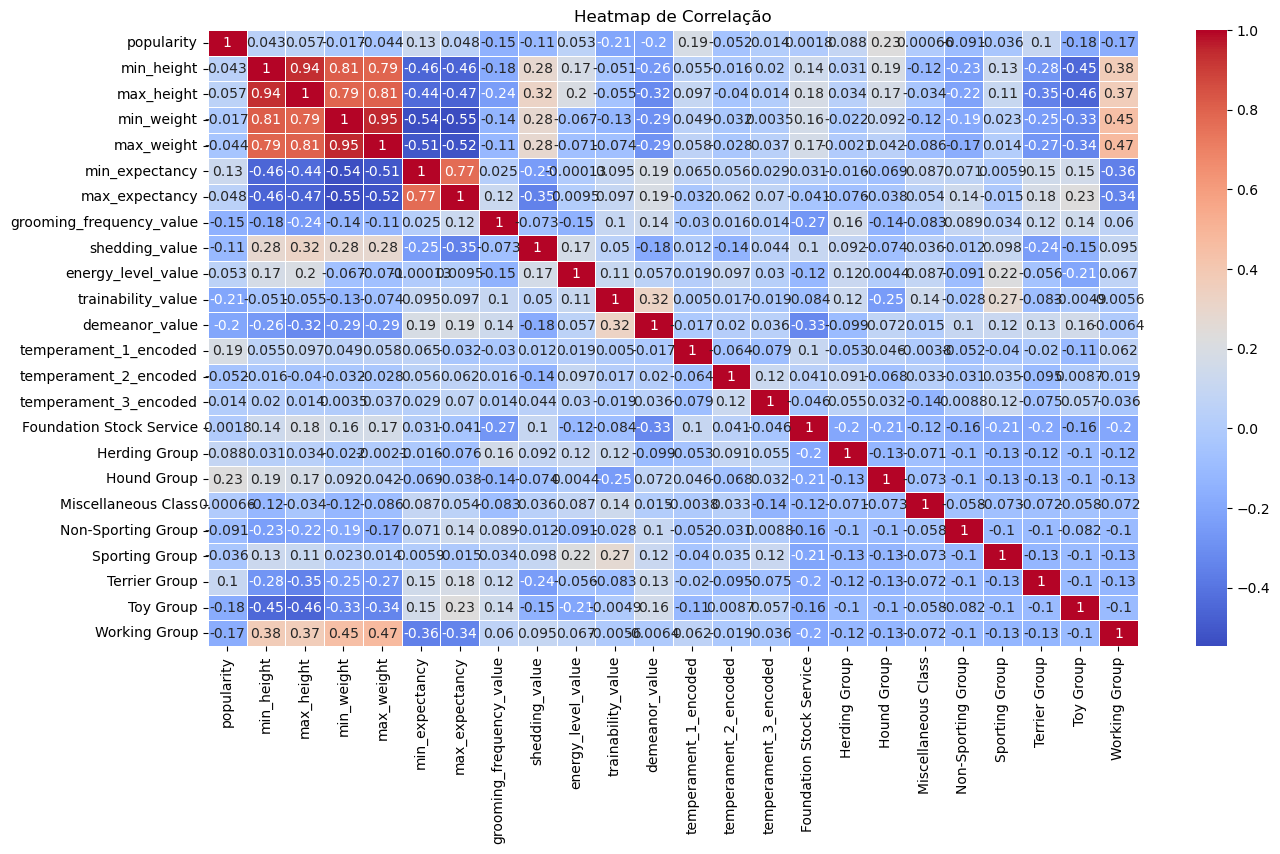

In [16]:
# Criar uma cópia do dataframe original
df_encoded = df.copy()

# Aplicar a codificação label encoding nas coluna de temperamento
label_encoder = LabelEncoder()
label_encoder.fit(temperament_values_sorted) # Ajustar o codificador com a lista de valores únicos
df_encoded['temperament_1_encoded'] = label_encoder.transform(df['temperament_1'])
df_encoded['temperament_2_encoded'] = label_encoder.transform(df['temperament_2'])
df_encoded['temperament_3_encoded'] = label_encoder.transform(df['temperament_3'])

# Aplicar a codificação one-hot encoding na coluna 'group'
df_encoded = pd.get_dummies(df_encoded, columns=['group'], prefix='', prefix_sep='')

# Calcular a matriz de correlação
correlation_matrix = df_encoded.corr()

# Plotar o heatmap de correlação
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de Correlação')
plt.show()

C:\Users\saman\AppData\Local\Temp\ipykernel_4952\2088748398.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


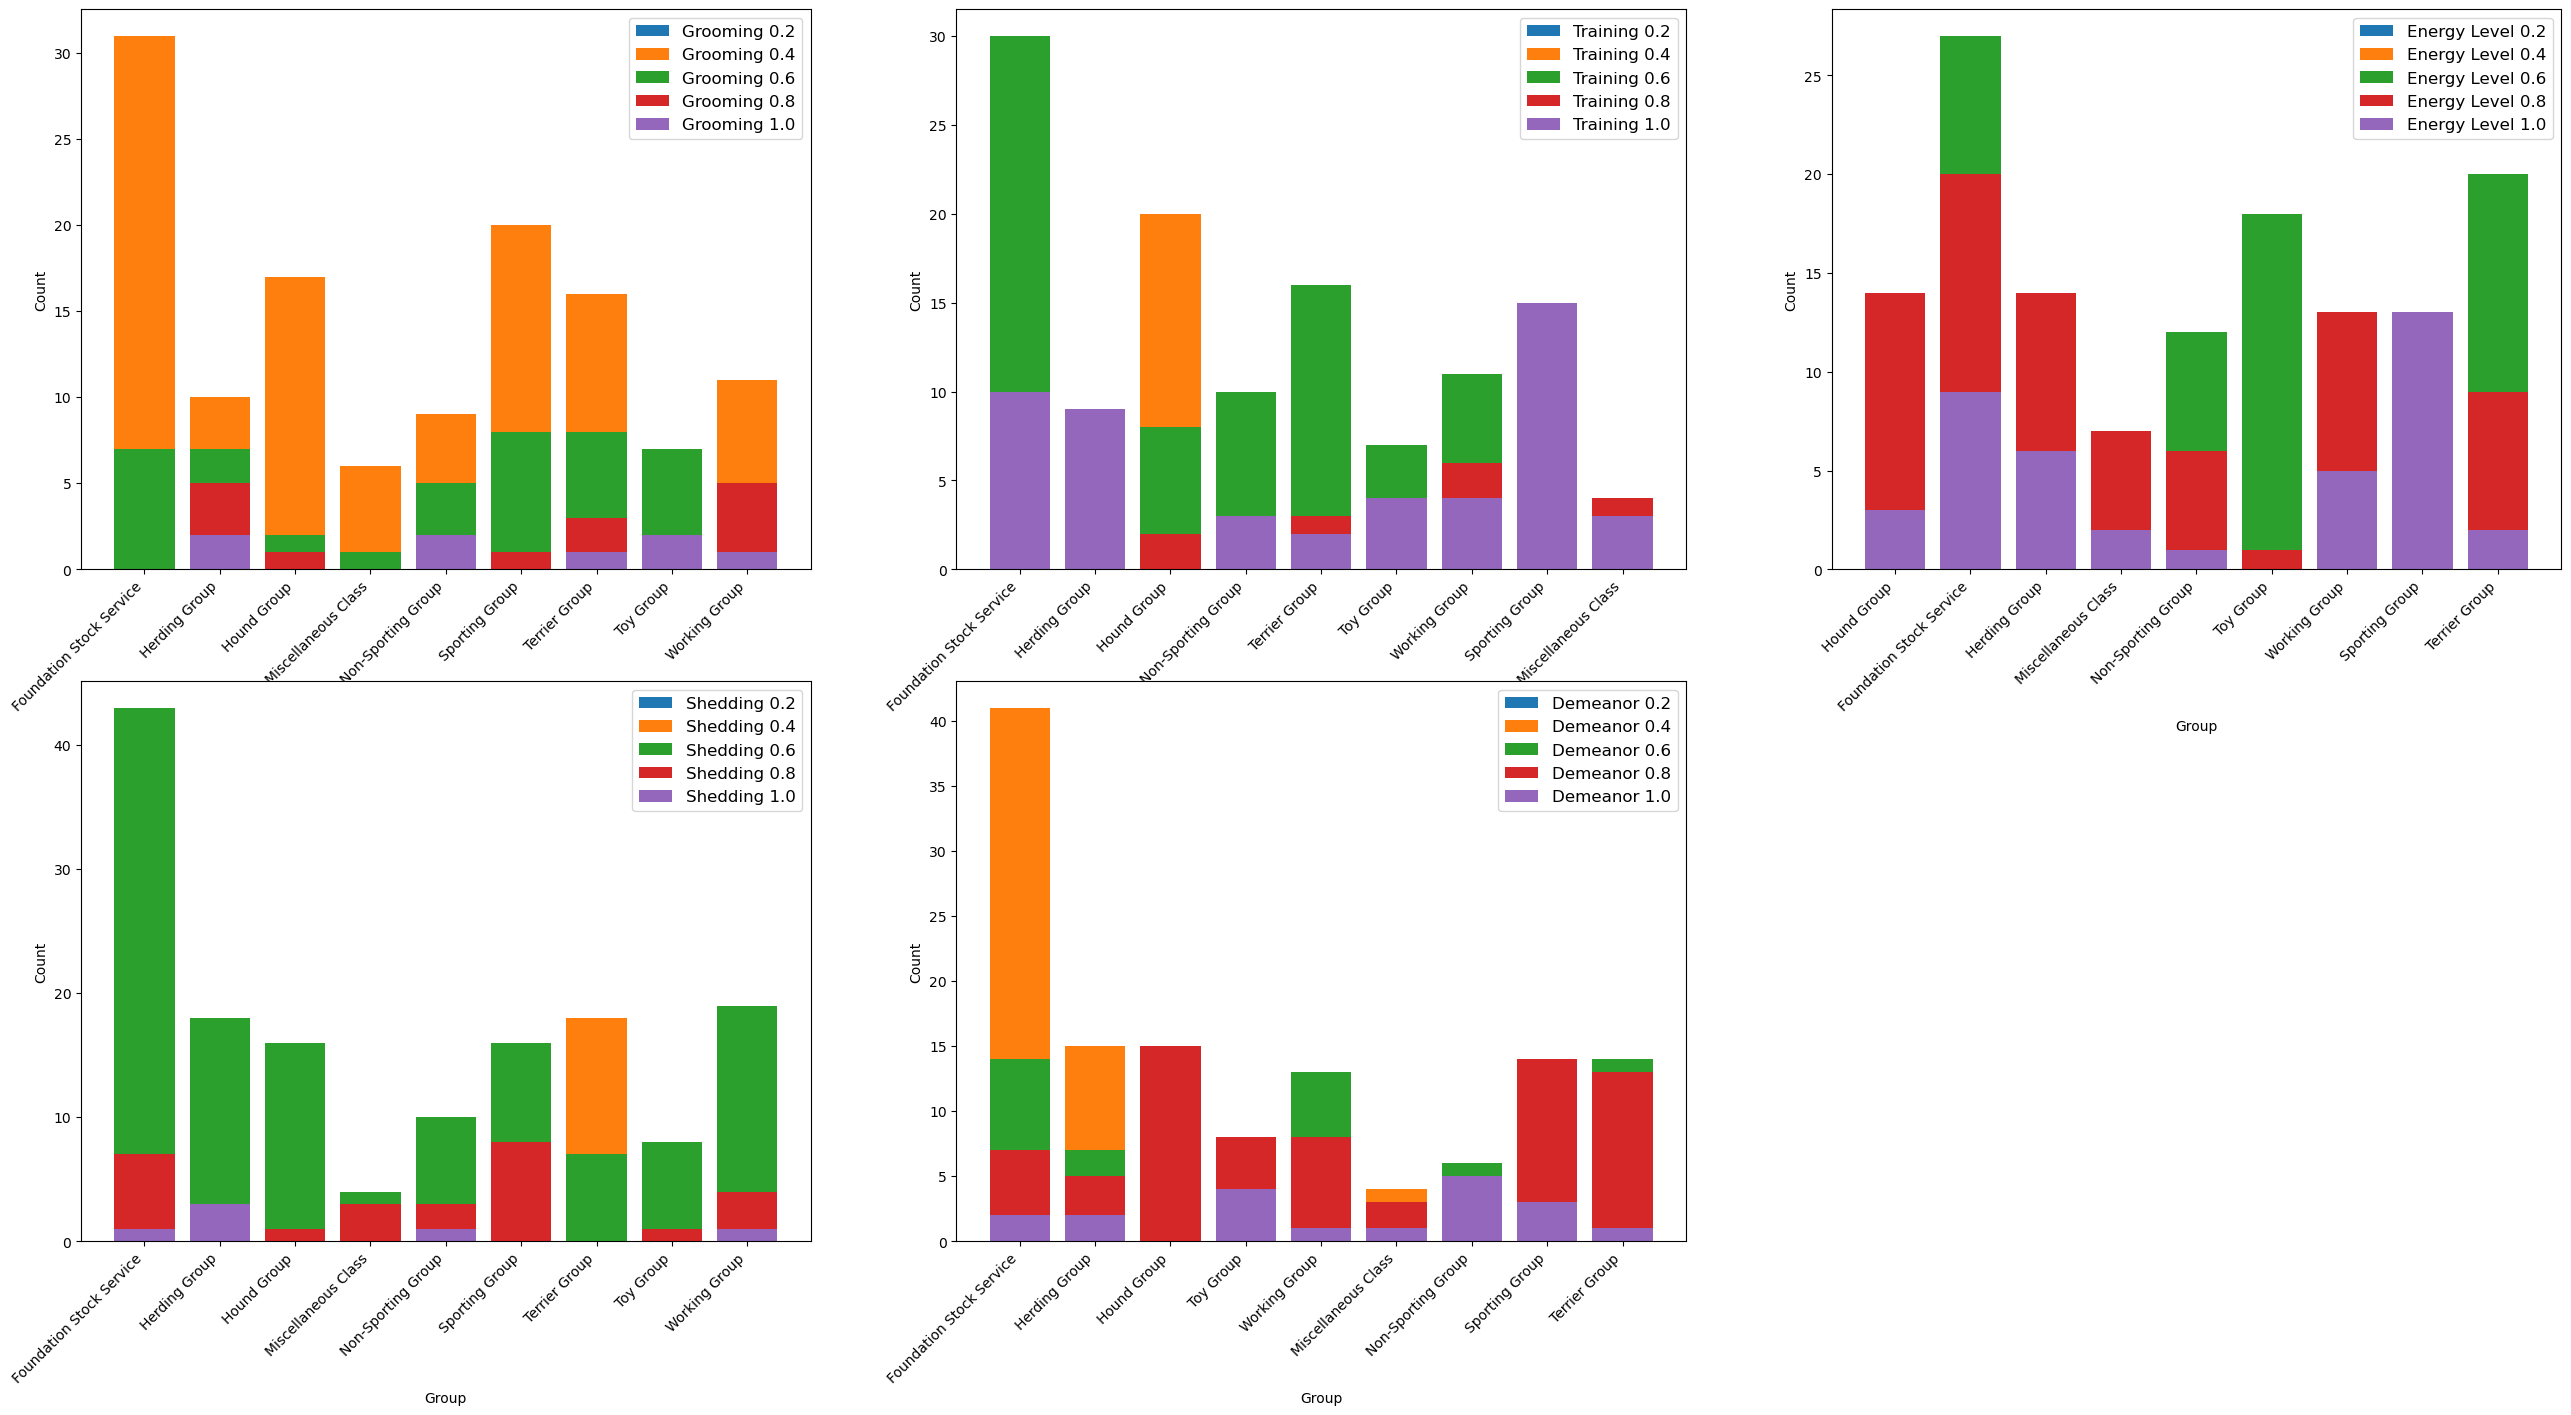

In [17]:
# Agrupando valores
grooming_plt = df.groupby(['group', 'grooming_frequency_value']).size().reset_index(name='count')
training_plt = df.groupby(['group', 'trainability_value']).size().reset_index(name='count')
energy_plt = df.groupby(['group', 'energy_level_value']).size().reset_index(name='count')
shedding_plt = df.groupby(['group', 'shedding_value']).size().reset_index(name='count')
demeanor_plt = df.groupby(['group', 'demeanor_value']).size().reset_index(name='count')
pop_plt = df.groupby(['group', 'popularity']).size().reset_index(name='count')

# Definir a ordem dos valores únicos de grooming_frequency_value
df_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Criar o gráfico de barras
fig, axes = plt.subplots(2, 3, figsize=(32, 16))
for i, value in enumerate(df_values):
    subset = grooming_plt[grooming_plt['grooming_frequency_value'] == value]
    axes[0, 0].bar(subset['group'], subset['count'], label=f'Grooming {value}')

    subset = training_plt[training_plt['trainability_value'] == value]
    axes[0, 1].bar(subset['group'], subset['count'], label=f'Training {value}')

    subset = energy_plt[energy_plt['energy_level_value'] == value]
    axes[0, 2].bar(subset['group'], subset['count'], label=f'Energy Level {value}')

    subset = shedding_plt[shedding_plt['shedding_value'] == value]
    axes[1, 0].bar(subset['group'], subset['count'], label=f'Shedding {value}')

    subset = demeanor_plt[demeanor_plt['demeanor_value'] == value]
    axes[1, 1].bar(subset['group'], subset['count'], label=f'Demeanor {value}')

# Remover os subplots vazios
fig.delaxes(axes[1, 2])

# Configurar os eixos, títulos e legendas
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('Group')
    ax.set_ylabel('Count')
    ax.legend(fontsize='large')

# Exibir a figura
plt.show()

## Questão 3
Defina um pipeline de redução de dimensionalidade, aplique e justifique sua escolha. Lembre de comparar a base reduzida com a original (ou mais próximo dela);

### Resolução
> O **PCA (Principal Component Analysis)** é uma técnica de redução utilizada para transformar um conjunto de variáveis correlacionadas (variáveis originais) em um novo conjunto de variáveis não correlacionadas (novos componentes principais) através de uma combinação linear. Assim, o PCA busca capturar a maior parte da variância dos dados em um menor número de dimensões.

Antes de realizar o redimensionamento, o dataframe possuia originalmente 14 colunas. A seguir foi utilizado o valor 9, mas o melhor valor de redução é aquele que melhor se aplica as métricas do modelo (acurácia, precisão e sensibilidade, vide questão 4).

A redução de dimensionalidade foi testada na questão 4 com diversos valores de `n_components` na aplicação do pipeline de redução. 

In [18]:
group_counts = df['group'].value_counts()
print(group_counts)

Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: group, dtype: int64


In [19]:
# realizando uma cópia do dataframe pré-processado
doggies = df.copy()

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(temperament_values_sorted) # Ajustar o codificador com a lista de valores únicos
doggies['temperament_1_encoded'] = label_encoder.transform(doggies['temperament_1'])
doggies['temperament_2_encoded'] = label_encoder.transform(doggies['temperament_2'])
doggies['temperament_3_encoded'] = label_encoder.transform(doggies['temperament_3'])

del doggies['popularity']
del doggies['temperament_1']
del doggies['temperament_2']
del doggies['temperament_3']


doggies.head()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,temperament_1_encoded,temperament_2_encoded,temperament_3_encoded
0,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,0.6,0.6,0.8,1.0,25,48,49
1,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,0.2,0.8,0.2,0.2,36,101,9
2,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,0.4,0.6,1.0,0.8,50,23,27
3,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,0.6,0.8,1.0,0.6,27,36,101
4,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,0.6,0.8,0.4,0.8,3,78,93


In [25]:
# Definindo atributo de entrada e saída
x = doggies.drop('group', axis=1) # Remover a coluna original 'group'
x = RobustScaler().fit_transform(x)

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Aplicar o label encoding à coluna 'group'
y = label_encoder.fit_transform(doggies['group'])

# Separando dados de treinamento (20% para testes e 80% para treinamento)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 1)

In [21]:
# Definir o pipeline k-NN
npca = 9
pipeline = Pipeline([
    ('scaling', StandardScaler()),  # Pré-processamento: normalização dos dados
    # ('feature_selection', SelectKBest(k=10)),  # Seleção das 10 melhores features
    ('dimensionality_reduction', PCA(n_components = npca)),  # Redução de dimensionalidade com PCA
])

x_train_df = pd.DataFrame(x_train)

# Aplicar o pipeline aos dados de treinamento
x_train_reduced = pipeline.fit_transform(x_train)
x_train_reduced_df = pd.DataFrame(x_train_reduced)

# Verificar as dimensões dos dados originais e reduzidos
print("Dataframe original")
print("Dimensões dos dados originais:", x_train.shape)
print(x_train_df.head())
print()
print("-"*100)
print("\nDataframe reduzido")
print("Dimensões dos dados reduzidos:", x_train_reduced.shape)
print(x_train_reduced_df.head())

Dataframe original
Dimensões dos dados originais: (221, 14)
         0         1        2         3    4    5    6    7    8    9    10  \
0  0.694444  0.545455  2.03125  1.630435 -2.5 -2.5 -0.5  0.0  1.0  0.0  0.0   
1  0.527778  0.500000  0.46875  0.217391  0.0  0.5 -0.5 -1.0  1.0 -0.5  1.0   
2  0.361111  0.545455  0.31250  0.543478 -0.5 -1.0  0.0  0.0  1.0  0.0  0.5   
3  0.583333  0.636364  0.93750  0.760870 -1.0  0.0 -0.5  0.0  0.0 -1.0 -0.5   
4  1.138889  1.000000  1.25000  1.195652 -2.0 -1.5 -0.5  0.0  0.0 -0.5  0.0   

         11        12        13  
0 -0.839286  0.265625 -0.794118  
1  0.000000  0.859375  1.029412  
2  1.178571 -0.406250  0.838235  
3 -0.803571 -0.234375  0.000000  
4  0.071429 -0.390625  0.426471  

----------------------------------------------------------------------------------------------------

Dataframe reduzido
Dimensões dos dados reduzidos: (221, 9)
          0         1         2         3         4         5         6  \
0  4.359974 -0.183548  1

In [22]:
# salvando em um novo arquivo .csv 

doggies.to_csv('dogs2.csv', index=False)

## Questão 4 (Supervisionado)
Defina um pipeline de aplicação de pelo menos 2 métodos de aprendizado de máquina supervisionado e da variação de ao menos 1 parâmetro deles, execute-o e justifique suas escolhas (sobre os métodos, parâmetros e valores);


### Resolução
**Em relação ao treinamento utilizando o método **k-NN**** (sem a técnica SMOTE)

A tabela a seguir apresenta o valor da acurácia (com e sem pipeline*) para cada valor de k utilizando o método k-NN. Dentre os valores obtidos, a melhor acurácia, sem a aplicação do pipeline de redução, foi para **`k = 1`** . Enquanto que a melhor acurácia, utilizando o pipeline de redução para `12` componentes, foi para **`k = 1`**.

| k-nn | Acurácia (s/ pipeline) |  Acurácia (PCA = 5) | Acurácia (PCA = 7) | Acurácia (PCA = 9) | Acurácia (PCA = 11) | Acurácia (PCA = 12) |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.44643 | 0.33929 | 0.42857 | 0.42857 | 0.51786 | 0.53571 |
| 3 | 0.39286 | 0.33929 | 0.33929 | 0.42857 | 0.35714 | 0.35714 |
| 5 | 0.35714 | 0.41071 | 0.37500 | 0.35714 | 0.39286 | 0.41071 |
| 7 | 0.41071 | 0.37500 | 0.30357 | 0.35714 | 0.46429 | 0.46429 |
| 9 | 0.35714 | 0.41071 | 0.37500 | 0.39286 | 0.48214 | 0.51786 |

<br/>

> _*_ Observação: note que na tabela foi indicado o número de componentes na aplicacação do PCA com o intuito e encontrar o melhor valor de redimensionamento dos dados.

**Em relação ao treinamento utilizando o método de Random Forest**

#### Dados de treinamento

In [30]:
# Definir os dados de teste
xd_test = np.array([
  [22.86,29.21,3.17514659,4.535923700000001,12.0,15.0,0.6,0.6,0.6,0.8,1.0,25,48,49], # Toy
  [63.5,68.58,22.6796185,27.2155422,12.0,15.0,0.8,0.2,0.8,0.2,0.2,36,101,9], # Hound
  [58.42,58.42,22.6796185,31.751465900000003,11.0,14.0,0.6,0.4,0.6,1.0,0.8,50,23,27], # Terrier
  [60.96,71.12,31.751465900000003,58.9670081,10.0,13.0,0.8,0.6,0.8,1.0,0.6,27,36,101], # Working
  [58.42,63.5,34.01942775,38.55535145,10.0,14.0,0.6,0.6,0.8,0.4,0.8,3,78,93], # Working
  [50.8,63.5,27.2155422,45.359237,10.0,12.0,0.2,0.6,0.8,0.6,0.6,78,112,131], # Foundation
  [58.42,66.04,20.41165665,29.48350405,11.0,12.0,0.2,0.4,0.8,0.6,0.6,123,80,117], # Hound
  [22.86,48.26,2.72155422,15.875732950000002,13.0,15.0,0.4,0.6,0.8,1.0,1.0,93,92,116], # Non-Sporting
  [53.34,63.5,27.2155422,31.751465900000003,11.0,13.0,0.2,0.6,0.8,0.4,0.8,66,40,125], # Hound
  [30.48,40.64,5.4431084400000005,7.25747792,14.0,16.0,0.4,0.4,0.6,0.6,0.6,41,5,29] # Terrier
])

'''
Toy
Hound
Terrier
Working
Working
Foundation
Hound
Non-sporting
Hound
Terrier
'''

'\nToy\nHound\nTerrier\nWorking\nWorking\nFoundation\nHound\nNon-sporting\nHound\nTerrier\n'

#### Treinamento do Modelo com k-NN
> **Sobre o método k-NN**:é um algoritmo é amplamente utilizado em problemas de reconhecimento de padrões, classificação de imagens, reconhecimento de caracteres manuscritos, processamento de fala e análise de dados biomédicos, entre outros. Este algoritmo utiliza os exemplos de treinamento k mais próximos ao exemplo de teste para realizar predições. 

* Atributo alvo: `group`
* KNN, k = {1, 3, 5, 7, 9}
* E para cada valor de k, foi calculada a:
  * Acurácia, 
  * Precisão,
  * e Sensibilidade do modelo

> Acurácia: mede, de maneira geral, a frequência que o classificador está correto. 

> Precisão: mede a incidência do modelo prever o grupo de um determinado cão, assim definindo o quão correta foi a precisão

> Sensibilidade: mede a capacidade do modelo identificar corretamente os casos positivos.

In [28]:
k_values = [1, 3, 5, 7, 9]
npca_list = [5, 7, 9, 11, 12]

for k in k_values:
  # Sem o pipeline
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(x_train, y_train)
  y_pred = knn_classifier.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  confusionm = confusion_matrix(y_test, y_pred)
  print("Sem pipeline")
  print(f"k = {k}: Acurácia = {accuracy:.5f}")
  print(f"k = {k}: Precisão = {precision:.5f}")
  print(f"k = {k}: Sensibilidade = {recall:.5f}")
  print(f'Matriz de Confusão: \n {confusionm}\n')


  # Com o pipeline
  for i in npca_list: 

    pipeline = Pipeline([
      ('scaling', StandardScaler()),
      ('dimensionality_reduction', PCA(n_components=i)),
      ('classification', KNeighborsClassifier(n_neighbors=k))
    ])
    pipeline.fit(x_train, y_train)
    x_test_reduced = pipeline['dimensionality_reduction'].transform(x_test)
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    confusionm = confusion_matrix(y_test, y_pred)
    print(f"Com pipeline, n_components PCA = {i}")
    print(f"k = {k}: Acurácia = {accuracy:.5f}")
    print(f"k = {k}: Precisão = {precision:.5f}")
    print(f"k = {k}: Sensibilidade = {recall:.5f}")
    print(f'Matriz de Confusão: \n {confusionm}\n')

  print("-"*100)


Sem pipeline
k = 1: Acurácia = 0.44643
k = 1: Precisão = 0.37671
k = 1: Sensibilidade = 0.38012
Matriz de Confusão: 
 [[5 1 2 0 0 2 1 0 2]
 [1 2 1 1 0 0 0 0 1]
 [0 1 3 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 0 1 0 0 1 1 0 0]
 [1 2 1 0 1 2 0 0 0]
 [0 0 1 0 0 0 8 0 0]
 [0 0 0 0 0 0 2 2 0]
 [0 0 3 1 0 0 0 0 3]]

Com pipeline, n_components PCA = 5
k = 1: Acurácia = 0.33929
k = 1: Precisão = 0.30423
k = 1: Sensibilidade = 0.27323
Matriz de Confusão: 
 [[7 0 2 0 0 2 0 0 2]
 [2 1 2 0 0 0 1 0 0]
 [3 1 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 1 0 0]
 [1 1 1 0 0 4 0 0 0]
 [4 1 1 0 1 0 1 1 0]
 [0 0 0 0 1 0 1 2 0]
 [2 0 1 0 0 0 0 0 4]]

Com pipeline, n_components PCA = 7
k = 1: Acurácia = 0.42857
k = 1: Precisão = 0.42593
k = 1: Sensibilidade = 0.37721
Matriz de Confusão: 
 [[6 1 1 1 0 0 2 0 2]
 [0 3 1 0 0 0 1 0 1]
 [1 1 3 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [2 0 1 0 0 0 1 0 0]
 [0 1 1 0 1 3 1 0 0]
 [3 2 0 0 0 1 3 0 0]
 [0 0 0 0 1 0 1 2 0]
 [1 0 1 1 0 0 0 0 4]]

Com pipeline, n_components PC

c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Com pipeline, n_components PCA = 11
k = 3: Acurácia = 0.35714
k = 3: Precisão = 0.29080
k = 3: Sensibilidade = 0.26979
Matriz de Confusão: 
 [[8 2 0 0 0 1 0 0 2]
 [3 2 0 0 0 0 0 1 0]
 [1 2 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [2 0 1 0 0 0 1 0 0]
 [2 2 1 0 1 1 0 0 0]
 [2 2 1 0 2 0 2 0 0]
 [1 0 0 0 1 0 2 0 0]
 [0 1 0 1 0 0 0 0 5]]

Com pipeline, n_components PCA = 12
k = 3: Acurácia = 0.35714
k = 3: Precisão = 0.26504
k = 3: Sensibilidade = 0.26979
Matriz de Confusão: 
 [[8 2 0 0 0 1 0 0 2]
 [3 2 0 0 0 0 0 1 0]
 [1 1 2 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [2 0 1 0 0 0 1 0 0]
 [2 2 1 0 1 1 0 0 0]
 [2 1 1 0 1 1 2 1 0]
 [1 0 0 1 0 0 2 0 0]
 [0 0 1 1 0 0 0 0 5]]

----------------------------------------------------------------------------------------------------
Sem pipeline
k = 5: Acurácia = 0.35714
k = 5: Precisão = 0.30260
k = 5: Sensibilidade = 0.29925
Matriz de Confusão: 
 [[6 3 1 0 0 0 1 0 2]
 [2 1 2 0 0 1 0 0 0]
 [2 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 1 1 1 0]
 [1 2 1 0 0 

c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

Com pipeline, n_components PCA = 12
k = 5: Acurácia = 0.41071
k = 5: Precisão = 0.29397
k = 5: Sensibilidade = 0.31140
Matriz de Confusão: 
 [[10  1  1  0  0  0  0  0  1]
 [ 2  0  2  0  0  1  0  1  0]
 [ 2  0  1  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 1  0  1  0  0  0  1  1  0]
 [ 2  1  1  0  0  3  0  0  0]
 [ 1  1  1  0  0  2  3  1  0]
 [ 0  0  0  0  0  0  2  2  0]
 [ 1  0  2  0  0  0  0  0  4]]

----------------------------------------------------------------------------------------------------
Sem pipeline
k = 7: Acurácia = 0.41071
k = 7: Precisão = 0.29103
k = 7: Sensibilidade = 0.29959
Matriz de Confusão: 
 [[9 2 0 0 0 0 1 0 1]
 [2 1 2 0 0 1 0 0 0]
 [3 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 1 0 0 0 1 1 0 0]
 [1 2 1 0 0 3 0 0 0]
 [1 1 0 0 0 1 4 2 0]
 [0 0 0 0 0 0 3 1 0]
 [0 0 1 1 0 0 0 0 5]]

Com pipeline, n_components PCA = 5
k = 7: Acurácia = 0.37500
k = 7: Precisão = 0.30688
k = 7: Sensibilidade = 0.28795
Matriz de Confusão: 
 [[8 0 2 0 0 1 1 0 1]
 [4 0 1 0 0 0 1 

c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

Sem pipeline
k = 9: Acurácia = 0.35714
k = 9: Precisão = 0.27174
k = 9: Sensibilidade = 0.26282
Matriz de Confusão: 
 [[8 1 1 0 0 1 1 0 1]
 [1 1 3 0 0 1 0 0 0]
 [3 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 1 0 0]
 [1 1 0 0 0 1 1 0 0]
 [2 1 1 0 0 2 1 0 0]
 [1 0 1 0 0 2 3 2 0]
 [1 0 0 0 0 0 2 1 0]
 [0 0 1 1 0 0 0 0 5]]

Com pipeline, n_components PCA = 5
k = 9: Acurácia = 0.41071
k = 9: Precisão = 0.32519
k = 9: Sensibilidade = 0.30885
Matriz de Confusão: 
 [[9 0 2 0 0 1 1 0 0]
 [4 0 1 0 0 0 1 0 0]
 [4 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 2 0 0 0 0 1 0 0]
 [2 1 0 0 0 4 0 0 0]
 [3 0 0 0 0 1 4 1 0]
 [0 0 0 0 0 0 2 2 0]
 [2 1 0 0 0 0 0 0 4]]

Com pipeline, n_components PCA = 7
k = 9: Acurácia = 0.37500
k = 9: Precisão = 0.29490
k = 9: Sensibilidade = 0.30057
Matriz de Confusão: 
 [[7 1 2 0 0 1 1 0 1]
 [1 2 2 0 0 0 1 0 0]
 [3 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 1 0 0 0 0 1 1 0]
 [4 1 0 0 0 2 0 0 0]
 [2 0 0 1 0 1 3 2 0]
 [0 0 0 0 0 0 2 2 0]
 [1 1 0 0 0 0 0 0 5]]

Com pipeline, n_components PC

c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

#### Testando k-nn

In [34]:
print("k-NN, Testando sem pipeline")

# Fazer previsões com o modelo k-NN
k = 1 # Escolha o valor de k desejado
knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(x_train, y_train)
predictions = knn_classifier.predict(xd_test)
print(predictions)

predicted_groups = label_encoder.inverse_transform(predictions)
print(predicted_groups)


k-NN, Testando sem pipeline
[0 0 8 0 0 0 0 0 0 8]
['Foundation Stock Service' 'Foundation Stock Service' 'Working Group'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service' 'Working Group']


In [36]:
# Definir o pipeline
npca = 12
k = 1

# Ajustar o scaler nos dados de treinamento
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Reduzir a dimensionalidade nos dados de treinamento
pca = PCA(n_components=npca)
x_train_reduced = pca.fit_transform(x_train_scaled)

# Criar o classificador KNN
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Treinar o classificador com os dados reduzidos
knn_classifier.fit(x_train_reduced, y_train)

# Aplicar o scaler e a redução de dimensionalidade nos dados de teste
x_test_scaled = scaler.transform(xd_test)
x_test_reduced = pca.transform(x_test_scaled)

# Fazer previsões com o classificador
y_pred = knn_classifier.predict(x_test_reduced)

# Imprimir as previsões
print(y_pred)

# Converter as previsões de volta para os rótulos originais
predicted_groups = label_encoder.inverse_transform(y_pred)
print(predicted_groups)

''' 
Toy ................... x
Hound ................. x
Terrier................ x
Working ............... x
Working ............... x
Foundation ............ v
Hound ................. v
Non-sporting .......... x
Hound ................. x
Terrier ............... x
'''

[0 8 8 0 0 0 2 1 8 2]
['Foundation Stock Service' 'Working Group' 'Working Group'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Hound Group' 'Herding Group' 'Working Group'
 'Hound Group']


' \nToy ................... x\nHound ................. x\nTerrier................ x\nWorking ............... x\nWorking ............... x\nFoundation ............ v\nHound ................. v\nNon-sporting .......... x\nHound ................. x\nTerrier ............... x\n'

#### Treinamento do Modelo com Random Forest

> `n_estimators`: o número de árvores na floresta. Quanto maior o número de estimadores, mais complexo será o modelo e maior será o tempo de treinamento. Um número maior de estimadores pode melhorar o desempenho do modelo, mas também aumentar o risco de overfitting.

> `max_depth`: a profundidade máxima de cada árvore na floresta. Controla a complexidade do modelo e a capacidade de generalização. Um valor mais alto pode levar a um modelo mais complexo, com maior tendência a overfitting.

> `criterion`: a medida de qualidade utilizada para avaliar a divisão dos nós durante a construção das árvores. O valor padrão é 'gini', que utiliza o índice de Gini como critério. Outra opção é 'entropy', que utiliza a entropia como critério. Esses critérios estão relacionados à pureza das divisões nos nós da árvore.

In [37]:
# Definir os parâmetros do Random Forest
n_estimators = 100

# Sem o pipeline
rf_classifier = RandomForestClassifier(n_estimators=n_estimators)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
confusionm = confusion_matrix(y_test, y_pred)
print("Sem pipeline")
print(f"Acurácia = {accuracy:.5f}")
print(f"Precisão = {precision:.5f}")
print(f"Sensibilidade = {recall:.5f}")
print(f'Matriz de Confusão: \n {confusionm}\n')

# Com o pipeline
pipeline = Pipeline([
  ('scaling', StandardScaler()),
  ('dimensionality_reduction', PCA(n_components=5)),
  ('classification', RandomForestClassifier(n_estimators=n_estimators))
])
pipeline.fit(x_train, y_train)
x_test_reduced = pipeline['dimensionality_reduction'].transform(x_test)
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
confusionm = confusion_matrix(y_test, y_pred)
print("Com pipeline")
print(f"Acurácia = {accuracy:.5f}")
print(f"Precisão = {precision:.5f}")
print(f"Sensibilidade = {recall:.5f}")
print(f'Matriz de Confusão: \n {confusionm}\n')

print("-"*100)


c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sem pipeline
Acurácia = 0.48214
Precisão = 0.38234
Sensibilidade = 0.38415
Matriz de Confusão: 
 [[9 1 1 0 0 0 1 0 1]
 [2 1 1 0 0 1 1 0 0]
 [2 1 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 1 1 0 0]
 [2 1 1 0 0 3 0 0 0]
 [1 0 1 0 1 1 5 0 0]
 [0 0 0 0 0 0 2 2 0]
 [0 0 1 0 0 1 0 0 5]]

Com pipeline
Acurácia = 0.33929
Precisão = 0.29305
Sensibilidade = 0.26998
Matriz de Confusão: 
 [[6 0 2 0 0 3 1 0 1]
 [1 1 2 0 0 1 0 0 1]
 [3 2 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 1 0 0 1 1 0 0]
 [2 1 0 0 1 3 0 0 0]
 [2 1 1 0 0 0 4 1 0]
 [0 0 0 0 0 0 2 2 0]
 [3 1 0 0 0 0 0 0 3]]

----------------------------------------------------------------------------------------------------


c:\Users\saman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Testando Random Forest

In [ ]:
# Fazer previsões com o modelo Random Forest
predictions = rf_classifier.predict(x_test)
print(predictions)

predicted_groups = label_encoder.inverse_transform(predictions)
print(predicted_groups)

## Questão 5 (Não-Supervisionado)

Defina um pipeline de aplicação de pelo menos 2 métodos de aprendizado de máquina não supervisionado e da variação de ao menos 1 parâmetro deles, execute-o e justifique suas escolhas (sobre os métodos, parâmetros e valores);

### Resolução

## Questão 6
Faça a comparação dos resultados (item 3, 4 e 5) utilizando pelo menos 2 métricas. Justifique a escolha dessas métricas e argumente sobre os resultados encontrados. Para tanto, você pode fazer um uso de gráficos e matrizes de confusão.


### Resolução